### Download Data

In [1]:
import pandas as pd
import numpy as np
# read data to pandas frame
url = 'https://raw.githubusercontent.com/Dr-Ning-An/Deep-Learning-with-Keras/main/FixedBeam/FixedBeamData.csv'
data = pd.read_csv(url)
data.shape
# print(data.head(5))

(5000, 4)

In [2]:
n = 5000; # data size

In [3]:
inputs = data.iloc[:, 0:2][0:n] # read the first two columns n size data as inputs
# Normalize the inputs
inputs_norm = (inputs - inputs.mean()) / inputs.std()
n_inputs_norm = inputs_norm.shape[1]
print(inputs_norm.head(5))
outputs = data.iloc[:, 2:4][0:n] # read the last two columns n size data as inputs
# Normalize the outputs
outputs_norm = (outputs - outputs.mean()) / outputs.std()
n_outputs_norm = outputs_norm.shape[1]
print(outputs_norm.head(5))

   Coordinate x [m]  Distributed load q [kN/m]
0         -1.455816                  -1.561807
1          0.923784                   1.380999
2          1.618613                   1.443347
3          1.435727                  -0.178383
4         -1.290942                   0.628672
   Displacement u [m]  Curvature kappa [m-1]
0            1.231600              -0.666018
1           -0.460458               0.218307
2            1.293882              -2.480789
3            1.116590              -1.089553
4            0.761128              -0.853157


In [4]:
from sklearn.model_selection import train_test_split
# Randomly split the data into a training and test sets by holding 30% of the data for testing.
inputs_norm_train, inputs_norm_test, outputs_norm_train, outputs_norm_test = \
    train_test_split(inputs_norm, outputs_norm, test_size = 0.3, random_state=0)

In [5]:
import keras
from keras.layers import Dense
import tensorflow as tf

# define regression model using Functional API
def build_model():
    # create model
    inputs = tf.keras.Input(shape=(n_inputs_norm,), dtype=tf.float64)
    dense1 = Dense(20, activation='tanh')(inputs)
    dense2 = Dense(20, activation='tanh')(dense1)
    dense3 = Dense(20, activation='tanh')(dense2)
    outputs = Dense(n_outputs_norm)(dense3)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# build the model
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 42        
                                                                 
Total params: 942
Trainable params: 942
Non-trainable params: 0
_________________________________________________________________


In [7]:
optimizer = tf.keras.optimizers.Adam()

In [8]:
BATCH_SIZE = 60
EPOCHS = 300

In [9]:
dataset = tf.data.Dataset.from_tensor_slices((inputs_norm_train, outputs_norm_train))
dataset = dataset.batch(BATCH_SIZE)

In [10]:
def PGNN(x_norm, q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        outputs_norm_pred = tf.cast(model(tf.stack([x_norm,q_norm], axis=1)), tf.float64)
        u_norm = outputs_norm_pred[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm) 
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm) 

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    kappa_norm = outputs_norm_pred[:,1]
    kappa = kappa_norm * outputs.std()[1] + outputs.mean()[1]
    
    residual = d2u_dx2 - kappa

    return residual

In [11]:
def train_step(inputs, outputs):
    with tf.GradientTape() as tape:
        outputs_pred = tf.cast(model(inputs), tf.float64)
        residual = PGNN(inputs[:,0],inputs[:,1])
        loss1 = tf.losses.MeanSquaredError()(outputs, outputs_pred) 
        loss2 = tf.reduce_mean(tf.square(residual))
        loss = loss1 + loss2

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

loss_hist = []
for epoch in range(EPOCHS):
    ep_loss = []
    for step, (inputs_norm_train_batch, outputs_norm_train_batch) in enumerate(dataset):
        loss_i = train_step(inputs_norm_train_batch, outputs_norm_train_batch)
        ep_loss.append(loss_i)

    if epoch % 1 == 0:
        print(f"Epoch {epoch} Loss: {tf.reduce_mean(ep_loss)}")

Epoch 0 Loss: 0.9010655696642865
Epoch 1 Loss: 0.8054615426386804
Epoch 2 Loss: 0.5853411282780495
Epoch 3 Loss: 0.2424496676803007
Epoch 4 Loss: 0.09239100179963629
Epoch 5 Loss: 0.058954841695411
Epoch 6 Loss: 0.04490816538487653
Epoch 7 Loss: 0.035500513253340346
Epoch 8 Loss: 0.028390329019625935
Epoch 9 Loss: 0.023074759915606657
Epoch 10 Loss: 0.019173499023337388
Epoch 11 Loss: 0.01633894084479776
Epoch 12 Loss: 0.014257559104991081
Epoch 13 Loss: 0.012660050860940165
Epoch 14 Loss: 0.011359727363495848
Epoch 15 Loss: 0.010239419555286795
Epoch 16 Loss: 0.009228505225219836
Epoch 17 Loss: 0.008287622097738218
Epoch 18 Loss: 0.007398128878483768
Epoch 19 Loss: 0.006555688229196923
Epoch 20 Loss: 0.005766171990651433
Epoch 21 Loss: 0.005041858319007241
Epoch 22 Loss: 0.004396757914037004
Epoch 23 Loss: 0.0038416375716733256
Epoch 24 Loss: 0.0033803167279954113
Epoch 25 Loss: 0.0030085145199400722
Epoch 26 Loss: 0.002715244574188608
Epoch 27 Loss: 0.0024857603169311606
Epoch 28 Los

In [12]:
test_data = outputs_norm_test * outputs.std() + outputs.mean()
print(test_data)
test_data_disp = test_data.to_numpy()[:,0]
test_data_kappa = test_data.to_numpy()[:,1]

      Displacement u [m]  Curvature kappa [m-1]
398        -6.665149e-06              -0.000001
3833       -3.351242e-06              -0.000001
4836       -5.442968e-06              -0.000003
4572       -1.357750e-05               0.000002
636        -1.138772e-05               0.000001
...                  ...                    ...
4554       -4.835997e-07              -0.000007
4807       -2.650817e-05               0.000004
1073       -2.767174e-05               0.000004
2906       -1.482808e-05               0.000002
1357       -8.275232e-07              -0.000008

[1500 rows x 2 columns]


In [13]:
pred_data_norm = model.predict(inputs_norm_test)
pred_data_norm_df = pd.DataFrame(pred_data_norm, columns = ['Displacement u [m]','Curvature kappa [m-1]'])
pred_data_df = pred_data_norm_df * outputs.std() + outputs.mean()
print(pred_data_df)
pred_data_disp = pred_data_df.to_numpy()[:,0]
pred_data_kappa = pred_data_df.to_numpy()[:,1]

47/47 [==============================] - 0s 1ms/step
      Displacement u [m]  Curvature kappa [m-1]
0          -6.662463e-06              -0.000001
1          -3.338377e-06              -0.000001
2          -5.434173e-06              -0.000003
3          -1.361121e-05               0.000002
4          -1.140867e-05               0.000001
...                  ...                    ...
1495       -5.424811e-07              -0.000008
1496       -2.655722e-05               0.000004
1497       -2.768279e-05               0.000004
1498       -1.486402e-05               0.000002
1499       -8.831183e-07              -0.000008

[1500 rows x 2 columns]


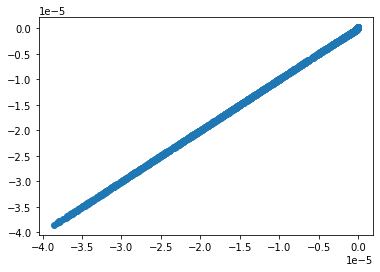

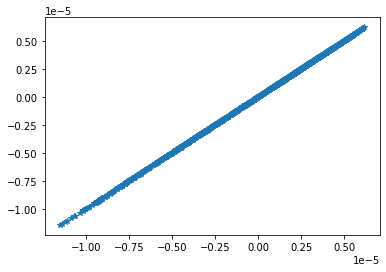

In [14]:
# Evaluate the mdoel on the test data and compare the error between predictions and true data
import matplotlib.pyplot as plt
plt.plot(test_data_disp, pred_data_disp, 'o')
plt.show()
plt.plot(test_data_kappa, pred_data_kappa, '*')
plt.show()

In [15]:
import tensorflow as tf
def F_model(model,x_norm,q_norm):
    x_norm = tf.Variable(x_norm)
    q_norm = tf.Variable(q_norm)
    with tf.GradientTape() as g:
      g.watch(x_norm)
      with tf.GradientTape() as gg:
        gg.watch(x_norm)
        u_norm = model(tf.stack([x_norm,q_norm], axis=1))[:,0]
      du_norm_dx_norm = gg.gradient(u_norm, x_norm)  
    d2u_norm_dx_norm2 = g.gradient(du_norm_dx_norm, x_norm)  

    # Chain rule
    du_du_norm = outputs.std()[0]
    dx_norm_dx = 1/inputs.std()[0]
    d2u_dx2 =  du_du_norm *  d2u_norm_dx_norm2 * dx_norm_dx**2

    u = u_norm * outputs.std()[0] + outputs.mean()[0]

    return u, d2u_dx2

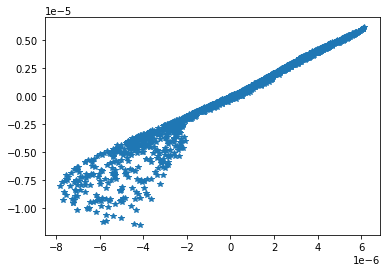

In [16]:
x_norm = inputs_norm_test.to_numpy()[:,0]
q_norm = inputs_norm_test.to_numpy()[:,1]
[u, d2u_dx2] = F_model(model, x_norm, q_norm)
# print(d2u_dx2)
plt.plot(d2u_dx2, test_data_kappa, '*')
plt.show()